# This notebook is intended to teach users how to interact with the SMUDGE N-body simulations presented in Hunt et al. 2021 (https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.1459H/abstract ). Our hope is that these tutorials are accessible to those with no experience using Python or Jupyter Notebooks. 

## DISCLAIMER: This notebook is a work in progress, please let us know if you have any issues!

## Please direct any questions about the functions in this notebook to Carrie Filion (cfilion@jhu.edu). If there are functions that you'd like to see, or suggestions that you have for how we can improve this guide, please contact Carrie. If you have specific questions about the simulations themselves, please contact Jason Hunt directly.

## Rachel McClure (rlmcclure@wisc.edu) is the primary author of the code used to interface with the simulations, with additions, revisions, et cetera from Carrie, Jason, and others.

the first time that you run this notebook, you'll probably have to import both galpy and gala & then restart the kernel (hit the little circle arrow, next to the black square!) after that, you can comment out the import gala and import galpy cells (put a pound sign before the text, like "#import galpy") and run everything like normal!

In [10]:
pip install galpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
#import necessary packages
import matplotlib.pyplot as plt
import matplotlib
from forsims_sciserver import SimHandler #this line is the code to use the simulations!
import datetime
from sys import getsizeof
import numpy as np

# SimHandler is a Python class for interacting with the SMUDGE simulations. We can load in a whole snapshot, or we can follow a given particle through the simulation. We have the option of loading only star particles, or loading both stars and dark matter. 

## classes are useful tools for this kind of work! If you are unfamiliar with classes, some documentation about what they are is available at this link: https://docs.python.org/3/tutorial/classes.html , with more information a short Google search away. 
An advantage of using a class here is that we can define some global properties that we want to apply to all functions that we use, allowing us to avoid having to constantly set parameters or variables. SimHandler is set up to know some of the properties of each simulation, so we can just tell the SimHandler what the name of the simulation is and it will already know some key features about the simulation, like the total number of star particles!

# Here, we provide examples of loading in a snapshot, and the things that you can do with a snapshot. We then pick some random particles from the simulation, and follow them throughout the simulation.

# An attribute is essentially just a variable/parameter that we set in a class! Some attributes of the SimHandler class that you may want to change are listed below, along with the default parameters for these attributes. The class contains many more attributes, but the defaults for those arguments generally should not be changed and/or are beyond the scope of this quick guide. 


### how much information do you want printed out any time you use a function? 
verbose = 0 -- default verbosity is zero but can go up to like 4 or 5. Higher numbers = more information printed out, this is useful for debugging!

### Do you want to recenter the individual snapshot that you're looking at?

recenter = False -- when you load in a single snapshot, do you want it to be recentered, such that X = Y = Z = 0 corresponds to the center of the disk galaxy? Change this to True if you want to recenter the snapshot you're loading in. This is especially useful for the simulations with mergers, as the center of the disk galaxy can move quite a bit



### If you downsample the data, what fraction of stars/dark matter particles do you want to look at?

downsamplefrac = 0.00005 -- fraction of the total # of stars to downsample to if you call the downsample function. The simulation is NOT automatically downsampled! You can change this to whatever you like. 


### some additional loading parameters - 
wdm = False -- toggle to load in dark matter and stars, or load only stars. The default is to load only stars. If you want both stars and dark matter, you can set this to True after calling the class (see below!)

barframe = False -- When you load a whole snap and/or particle path, do you want to transform it into the bar frame? Setting this to True only works if there is a file of the pattern speed of the bar over time 


### some attributes for following a single particle over time -

start = 0 -- If you are following the path of a particle over time, at what time step do you want to start following the particle? The default is to start at the first timestep (i.e. index = 0), but this can be changed depending on what you want to do! E.g. it could be useful to follow a particle after the formation of the bar

finish = None -- If you are following the path of a particle over time, at what time step do you want to stop following the particle? The default is to end at last time step of simulation, but again you can change this to suit your needs!

# when you start using SimHandler, you need to pass in what simulation you want to use. The simulation names match those given in Hunt et al 2021, where you can also find the parameters for each of the simulations. We have two merger models (M1 and M2), and two isolated, merger-free models (D1 and D2)

### The simulation name is also the name of the folder holding the data within each of the data volumes on SciServer. 

## In this notebook, we look at simulation M1. We currently have all four simulations hosted on SciServer, and all functions in this notebook should work for M1, M2, and D2 - please let us know if you find that this is not true for M2 and/or D2!


putting %%time at the beginning of a cell makes a little printout that tells us how long it takes to run the code in the cell

To use the SimHandler class, we need to call it and tell it what simulation we want to use. This makes an "instance"
of the class that knows that we are using the specified simulation. We need to name this instance so that we can use it to load snapshots etc!

In [4]:
%%time 
sim = 'M1' #the name of the simulation that you want to look at
simM1 = SimHandler(sim) #Make an instance (here we name the instance simM1) by calling the SimHandler class & 
#giving it the simulation name 

start init at: 2023-10-16 11:32:38.241868
end at: 2023-10-16 11:32:38.247686
CPU times: user 5.35 ms, sys: 4.14 ms, total: 9.49 ms
Wall time: 7.56 ms


now that we have an instance, we can change some of the attributes given above. For example, if you wanted to load  in dark matter, you would un-comment the line below (aka remove the "#" in front of the text)simM1.wdm = True the default when we load the SimHandler class is wdm = False. Loading in the dark matter takes a lot of memory, and can make this notebook very slow. If you want to use dark matter, it may be best to submit a Compute Job


In [ ]:
#we will skip recentering the snapshot for now - if we wanted to recenter the snapshot, we would uncomment
#the line below.
##simM1.recenter = True 

# now that we have our simM1 instance, we can use the functions within the class! Here, we use loadwholesnap and loadonesource. We'll also downsample the snapshot (aka take a random subset of the full snapshot) which will speed up things (like plotting)!

## loadwholesnap is how we load in a whole time step (aka snapshot) of the simulation - this gives us information about all of the particles at a given time. Remember: we are loading in only stars 

## The input into loadwholesnap is the time step index (i.e. what time step you want to look at - note that the numbering starts at zero, so passing time step index = 100, for example, gives you the 101st item in the time step array). 

## How do you know what physical time corresponds to a given step index? See below!

In [5]:
# to get an array of the time steps in the simulation, run this command below! This returns an array of all of
#the snapshot names, and below we show you how to convert a given time step name to the physical time of the snapshot
times = simM1.gettimes(return_array=True)

print(times)

['snapshot__00001.0010-0', 'snapshot__00002.0000-0', 'snapshot__00003.0010-0', 'snapshot__00004.0009-0', 'snapshot__00005.0008-0', 'snapshot__00006.0007-0', 'snapshot__00007.0007-0', 'snapshot__00008.0006-0', 'snapshot__00009.0000-0', 'snapshot__00010.0004-0', 'snapshot__00011.0008-0', 'snapshot__00012.0002-0', 'snapshot__00013.0006-0', 'snapshot__00014.0000-0', 'snapshot__00015.0004-0', 'snapshot__00016.0008-0', 'snapshot__00017.0003-0', 'snapshot__00018.0007-0', 'snapshot__00019.0002-0', 'snapshot__00020.0006-0', 'snapshot__00021.0001-0', 'snapshot__00022.0005-0', 'snapshot__00023.0010-0', 'snapshot__00024.0004-0', 'snapshot__00025.0009-0', 'snapshot__00026.0003-0', 'snapshot__00027.0008-0', 'snapshot__00028.0002-0', 'snapshot__00029.0007-0', 'snapshot__00030.0001-0', 'snapshot__00031.0006-0', 'snapshot__00032.0000-0', 'snapshot__00033.0005-0', 'snapshot__00034.0009-0', 'snapshot__00035.0004-0', 'snapshot__00036.0008-0', 'snapshot__00037.0003-0', 'snapshot__00038.0007-0', 'snapshot__

In [6]:
#let's load time index 703! this is after the dwarf galaxy has passed nearby, and is also approximately our 
#"present day" snapshot (see Hunt et al 2021) 
snapshot_name = times[702] #indexing starts at zero - 702 gives us 703rd item
print('we have selected', snapshot_name)
print('this name is a', type(snapshot_name)) #let's also print out the data type of snapshot_name

we have selected snapshot__00703.0029-0
this name is a <class 'str'>


snapshot_name is a string! strings are a data type that can be used for text to go from the snapshot name printed above to a physical time, we need to get just the numbers after "snapshot" but before "-0". To do this, we use string splitting! See below for how this works, and/or Google for more info on string splitting!

In [7]:
split_name = snapshot_name.split('__')[1] #we want to separate the string into stuff before the "__" and stuff after.
#This is the .split('___') part of the above line! This line returns a list, the first item in the list is the stuff 
#before '___', and the second item is stuff after '___'. We want what is after the '___' so we use [1] to select this 
#(remember - indexing starts at zero! the first item in the list would be at [0])
print(split_name) #this is what is after '___' in the snapshot name
#we can do another round of string splitting to get the stuff before '-'
t = float(split_name.split('-')[0]) #we split the string and select what we want, same as before, but now we also
#turn the stuff before the '-' into a float! A float is a data type, and floats are real numbers that have decimal 
#places. We can multiply floats, we can't multiply strings!
print(t)

00703.0029-0
703.0029


To convert the numbers given in the snapshot names, we multiply the numbers by a conversion factor. This conversion factor is the same in all simulations hosted here, and converts from the numbers in the snapshot name to millions of years (physical units!). When you use loadwholesnap or other functions in SimHandler, this is conversion is automatically done for you, but we wanted to show you how to do this conversion so that you can make sense of the file names!

In [8]:
time_conversion = 9.778145 #this is the conversion factor 
print('the physical time corresponding to the chosen time index is', t*time_conversion, 'million years',
     '- aka ', t*time_conversion / 1000, 'billion years')

the physical time corresponding to the chosen time index is 6874.0642916205 million years - aka  6.8740642916205 billion years


### Disclaimer: It can take a few minutes to load in a single snapshot! 

In [9]:
%%time 
#now that we know what physical time corresponds to time index 703, let's load the snapshot!
#if we loaded in dark matter, we would write: full_snap, full_dark = simM1.loadwholesnap(702) 
full_snap = simM1.loadwholesnap(702) 

CPU times: user 2min 5s, sys: 3min 51s, total: 5min 56s
Wall time: 6min 8s


loadwholesnap gives us a structured array of the star particles. Structured arrays are awesome! We'll show you more below. If you want more information, this link is helpful: https://jakevdp.github.io/PythonDataScienceHandbook/02.09-structured-data-numpy.html

In [10]:
#note! this array contains both star particles of the big, disk galaxy and the dwarf galaxy satellite - 
#we show you how to separate out these particles below!
print('there are', len(full_snap), ' star particles')

there are 241721919  star particles


In [11]:
#That's a lot of particles! let's down sample this to make the following steps a bit faster and less computationally
#intensive - we don't need to keep all of the particles for what we want to do here!
simM1.downsamplefrac = 0.0005 #lets keep 0.05% of all particles. this is changing a class attribute!

snap = simM1.downsamplesnap(full_snap)
print('there are', len(snap), ' star particles in downsampled data!')

there are 120861  star particles in downsampled data!


# what does this output look like?
## Each snapshot is a structured numpy array. The columns are t (time in Gyr), x (cartesian x-coordinate in kpc), y (cartesian y-coordinate in kpc), z (cartesian z-coordinate in kpc), vx (velocity in x in km/s), vy (velocity in y in km/s), vz (velocity in z in km/s), mass (the mass of the particle - this is effectively just flag so we can select disk, bulge, or dwarf satellite galaxy star particles. Similar can be done for dark matter to look at dwarf galaxy or disk galaxy), idd (unique particle IDS). Note that numpy array indexes start from zero. Let's look at how to interact with these structured arrays:


In [12]:
#We can look at the time information for ALL stellar particles
print(snap['t']) #"snap" is our array of star particles and "t" is our time column
#all of the entries in this column are identical! This is because we loaded in a single snapshot, which gives us
#all of the information for all of the particles at a single time step! 
#note that time step ID 703 corresponds to ~6.874 Gyr, as we found above!

#what about the info in the x column? Let's look at the first 5 entries 
print('the X location of the first five particles in this snapshot:', snap['x'][0:5]) 
#[0:5] is array slicing. We select five total items, from index = 0 up to (but not including) index = 5. 
#remember, since indexing starts at zero, index = 5 is the SIXTH item in the array

[6.87406399 6.87406399 6.87406399 ... 6.87406399 6.87406399 6.87406399]
the X location of the first five particles in this snapshot: [11.065426  12.574233   8.664388  14.992991   4.3954887]


## There are different kinds of star and dark matter particles! Each type of particle has a unique mass, and we can use this fact to separate out the different components of the simulation. In simulation M1, there are three types of star particle: dwarf galaxy star particles, disk star particles in the disk galaxy, and bulge star particles in the disk galaxy. Similarly, there are dark matter particles in the disk galaxy and dark matter particles in the dwarf galaxy.


### A quick way to see what kinds of particles there are is to look at the unique mass values in the snapshot. Remember, the star particles are in a separate array from the dark matter particles - aka the masses in the "snap" array we define above will only be masses for star particles, so we won't see the masses for dark matter particles! The disk particles in the disk galaxy will be the least massive, dwarf galaxy particles (if there is a dwarf galaxy in the simulation) will be the most massive particles, and the bulge particles in the disk galaxy will be more massive than the disk star particles but less massive than the dwarf star particles

In [13]:
# what are the unique stellar masses? what are the unique dark matter masses?
print('unique masses in the stellar component of this snapshot:', np.unique(snap['mass']))

unique masses in the stellar component of this snapshot: [ 160.10631  540.6143  4236.0166 ]


### A good sanity check - make sure that these values match what is given in Hunt et al 2021!

### as explained above (and in Hunt et al 2021), we know the disk star particles have masses of ~200 Msun, the bulge particles have masses of ~500 Msun, and the dwarf galaxy particles have masses of ~4,000 Msun. The disk galaxy dark matter particles have masses of ~700 Msun, and the dwarf galaxy dark matter particles have masses of ~20,000 Msun. Let's use this information to select each type of particle and plot them separately!

here, we make flags to select disk stars, bulge stars, and dwarf galaxy stars. We use generous mass bounds to select the different types of stars, even though we know the exact value of the masses we do this so that we can use these flags for all of the simulations we use! The exact value of disk star masses etc changes a bit from simulation to simulation, so we want to be sure we give ourselves some wiggle room in this selection!

In [14]:
disk_flag = (snap['mass']<200) #we select stars with mass < 200 as disk stars (we know disk particle mass from above)
bulge_flag = (snap['mass']>200)&(snap['mass']<700) #bulge stars have masses between the disk particles and the 
#dwarf galaxy particles. We select stars with masses between 200 and 700 Msun as bulge stars.
dwarf_flag = (snap['mass']>700) #dwarf galaxy star particles are the most massive, select stars with mass > 700!
#these flags will select stars in the snap array that have masses meeting the criteria of that flag! see how
#to use these flags below


#lets check how many of disk, bulge, and dwarf galaxy star particles there are. 
#Since we downsampled, these #s won't match those given in Hunt et al 2021!
print('there are', len(snap[disk_flag]), 'disk star particles',
      'there are', len(snap[bulge_flag]), 'bulge star particles',
      'there are', len(snap[dwarf_flag]), 'dwarf star particles',
     'in the down-sampled simulation')
#we'll skip the dark matter for now -

there are 109947 disk star particles there are 10848 bulge star particles there are 66 dwarf star particles in the down-sampled simulation


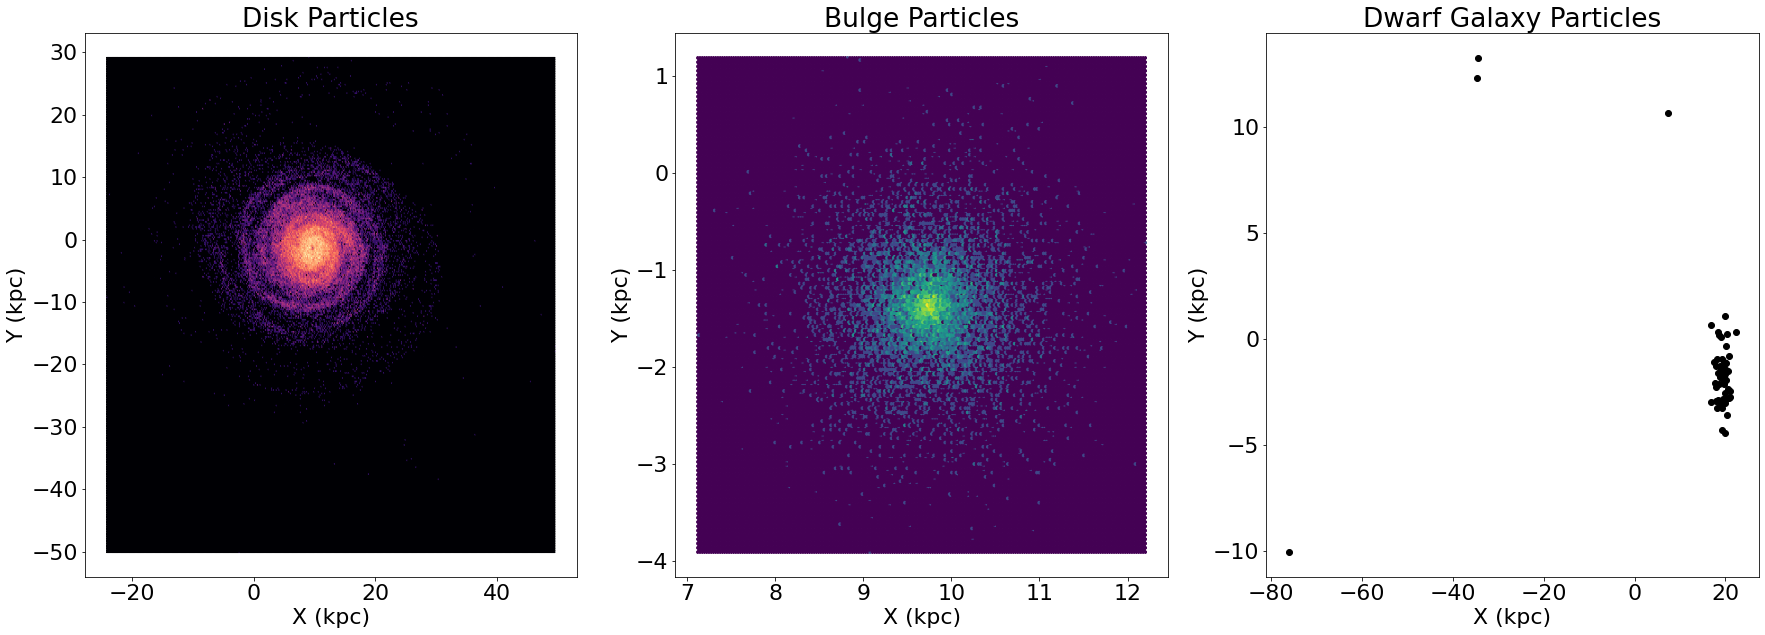

In [15]:
#lets plot a 2d histogram of these star particles! We use hexbins in matplotlib to do this, as it is a bit faster
#than the hist2d function for large quantities of data. We encourage you to look at the plotting documentation!
from matplotlib import colors
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(30,10)) #three plots, side by side, size of 10 x 10 each
ax1.set_title('Disk Particles') #give the first plot a title
ax1.hexbin(snap[disk_flag]['x'],snap[disk_flag]['y'], gridsize=500,cmap='magma',norm=colors.LogNorm())
#gridsize sets the size of each bin, cmap is the colormap, and norm is the color scaling. 
ax1.set_xlabel('X (kpc)')
ax1.set_ylabel('Y (kpc)')

ax2.set_title('Bulge Particles') #give the second plot a title
ax2.hexbin(snap[bulge_flag]['x'],snap[bulge_flag]['y'], gridsize=200,cmap='viridis',norm=colors.LogNorm())
ax2.set_xlabel('X (kpc)')
ax2.set_ylabel('Y (kpc)')


ax3.set_title('Dwarf Galaxy Particles') #give the third plot a title
ax3.scatter(snap[dwarf_flag]['x'],snap[dwarf_flag]['y'], c='k') 
#just going to do a scatter plot here, as there are few dwarf galaxy particles(see the numbers above!)
ax3.set_xlabel('X (kpc)')
ax3.set_ylabel('Y (kpc)')
#save figure as a jpeg
plt.savefig('disk_bulge_dwarf_plot.jpeg') 

### Look at that beautiful spiral! You can see that the disk galaxy is no longer centered on (X, Y) = (0, 0) - this is why we have built in the option to re-center the galaxy!

# Let's pick some star particles and look at their positions over time!
## To follow a particle over time, we use the loadonesource function in SimHandler. The input into this function is a particle id (from the 'IDD' column in the structured array), and time indexes for where you want to start and stop following the particle. You can also opt to have the coordinates be re-centered, or you can transform into the bar frame (which requires that the disk galaxy be recentered first! This is done internally.)

## loadonesource will work for M1, M2 and D2. Similarly, each of these simulations can be transformed into the bar frame. 

### loadonesource returns a structured array with the same columns as loadwholesnap (i.e. x, y, z, vx, vy, vz, mass, t, idd)

In [16]:
#lets pick some random IDS from here - we'll follow these particles over time in the next few cells!
#we've just picked some random numbers here. Some stars will be in the disk galaxy, and some in the dwarf galaxy!
some_ids = np.array([snap['idd'][100], #here, we select the the particle ID at index 100 (aka the 101st ID!)
                     snap['idd'][89765],
                     snap['idd'][12343],
                     snap['idd'][45076],
                     snap['idd'][8321],
                     snap['idd'][10985],
                     snap['idd'][92354],
                     snap['idd'][4],
                     snap['idd'][26894],
                     snap['idd'][99999]])
np.savetxt('some_particle_ids.txt', some_ids) #save these ids so that we can look at them later!

let's follow the paths of some particles! Below we use loadonesource, and specify that we want to follow the particle from the first time index to the last (note that finish = None means it will follow the particle until the end of the simulation. The code will print out what index this corresponds to). Of course, you can change these to look at just portions of the path! we also print the mass of the chosen particle so we know which component it belongs to!


In [17]:
#let's pick the first item of the array of IDs that we made in the cell above. We ensure that this ID is an integer
#by saying int(some_ids[0]). We also print the mass of this particle!
path_0 = simM1.loadonesource(int(some_ids[0]),start=0,finish=None)  
print('mass of particle 0', path_0['mass'][0]) #we select the first mass in the array - all masses in the array
#are identical! we don't need to look at alllll of them

path_1 = simM1.loadonesource(int(some_ids[1]),start=0,finish=None)  
print('mass of particle 1', path_1['mass'][0])

path_2 = simM1.loadonesource(int(some_ids[2]),start=0,finish=None) 
print('mass of particle 2', path_2['mass'][9])


ATTN: Setting finish tind as  848
found pointer path
mass of particle 0 160.10631
ATTN: Setting finish tind as  848
found pointer path
mass of particle 1 540.6143
ATTN: Setting finish tind as  848
found pointer path
mass of particle 2 160.10631


### let's plot these particle paths!

Text(0, 0.5, 'Z (kpc)')

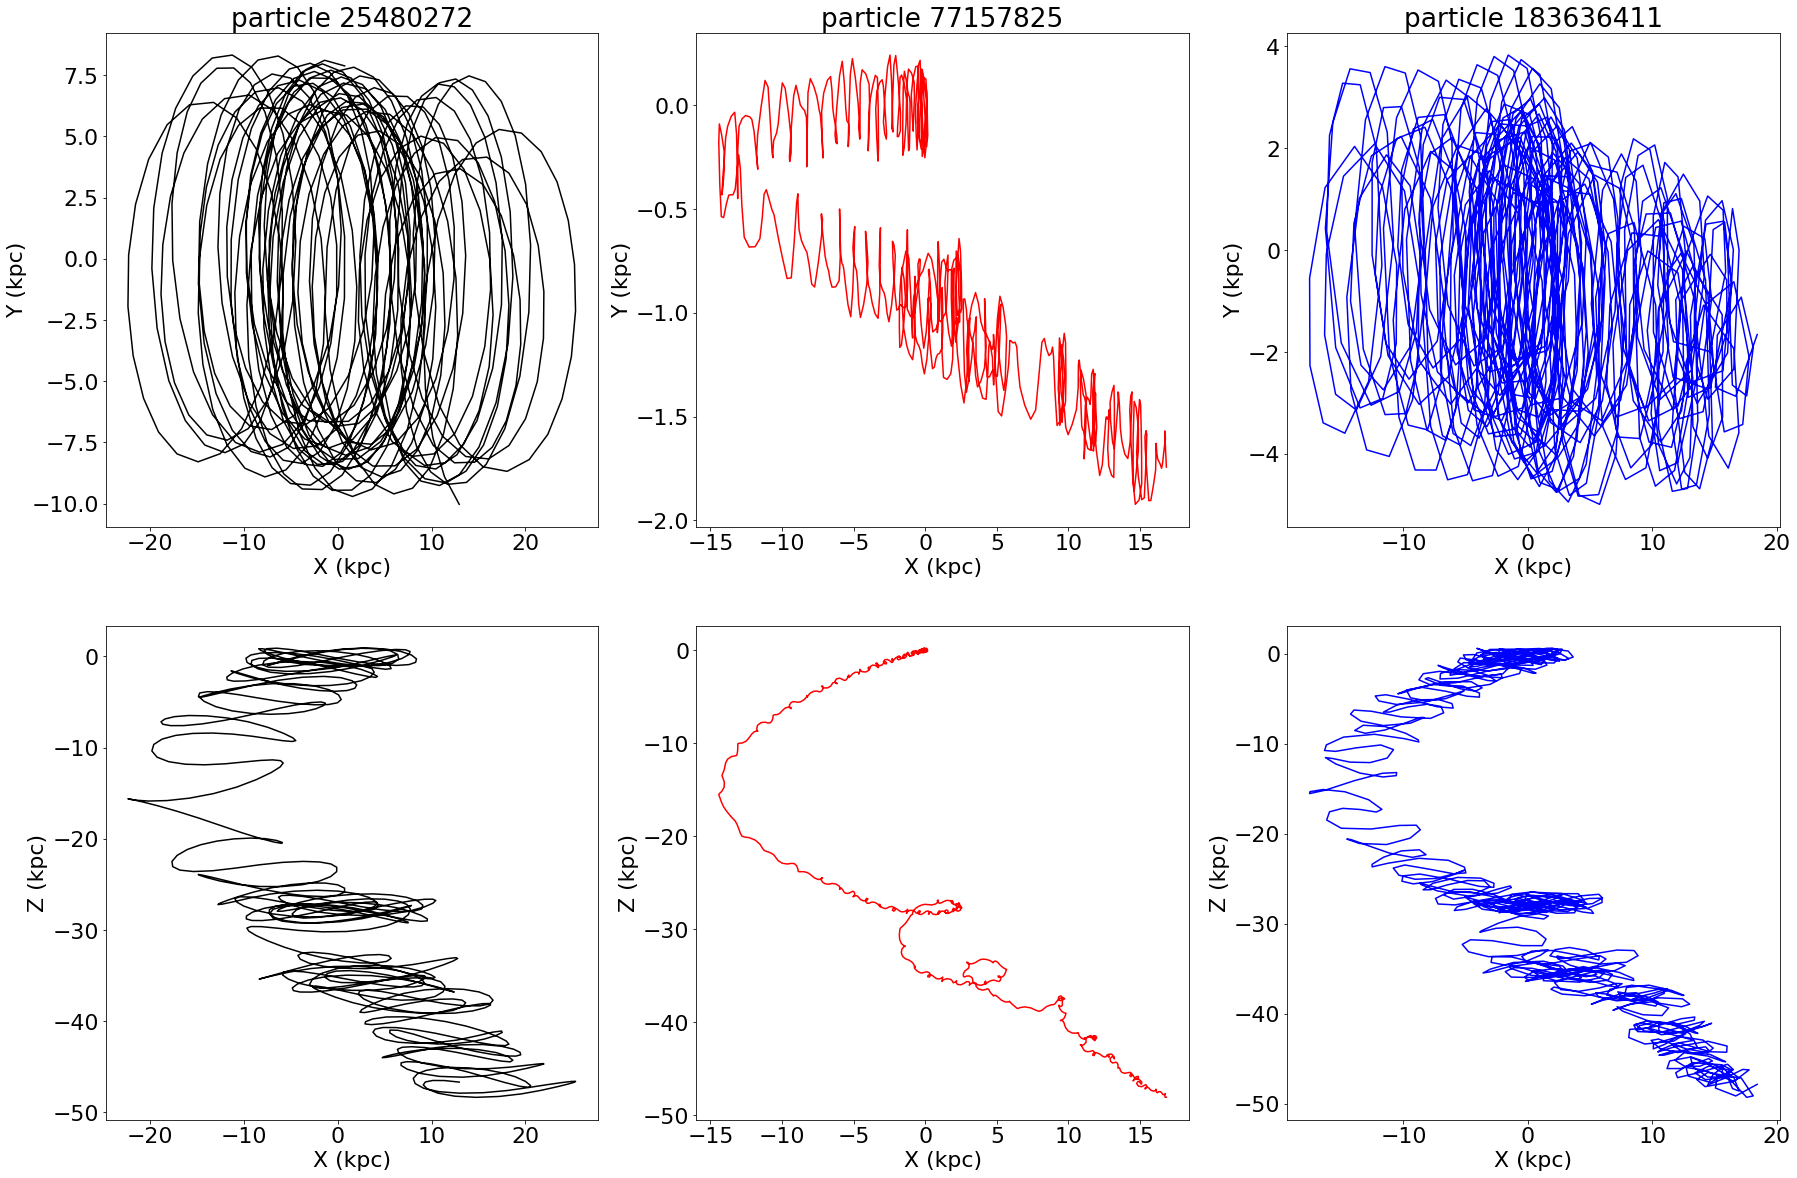

In [18]:
#let's plot the paths of these particles!
#we can get a string that tells us the particle ID like so: str(path_0['idd'][0])
#the [0] here is the same as above - we only want to see the first entry! 
fig, (ax1, ax2) = plt.subplots(2,3, figsize=(30, 20)) #two rows of three plots, size 10x10 each
ax1[0].set_title('particle '+ str(path_0['idd'][0])) #title the plot with the particle ID
ax1[0].plot(path_0['x'], path_0['y'], c='k') #a plot of x vs y, shown with a black line
ax1[0].set_xlabel('X (kpc)') #set axis labels
ax1[0].set_ylabel('Y (kpc)')

ax2[0].plot(path_0['x'], path_0['z'], c='k') #a plot of x vs z, shown with a black line
ax2[0].set_xlabel('X (kpc)') #set axis labels
ax2[0].set_ylabel('Z (kpc)')

#next particle path!
ax1[1].set_title('particle '+ str(path_1['idd'][0])) 
ax1[1].plot(path_1['x'], path_1['y'], c='r') #a plot of x vs y, shown with a red line
ax1[1].set_xlabel('X (kpc)') #set axis labels
ax1[1].set_ylabel('Y (kpc)')

ax2[1].plot(path_1['x'], path_1['z'], c='r') #a plot of x vs z, shown with a red line
ax2[1].set_xlabel('X (kpc)') 
ax2[1].set_ylabel('Z (kpc)')

#next particle path!
ax1[2].set_title('particle '+ str(path_2['idd'][0])) #title the plot with the particle ID
ax1[2].plot(path_2['x'], path_2['y'], c='b') #a plot of x vs y, shown with a blue line
ax1[2].set_xlabel('X (kpc)') #set axis labels
ax1[2].set_ylabel('Y (kpc)')

ax2[2].plot(path_2['x'], path_2['z'], c='b') #a plot of x vs z, shown with a blue line
ax2[2].set_xlabel('X (kpc)') #set axis labels
ax2[2].set_ylabel('Z (kpc)')

# wow - these are some weird looking plots! We know that our galaxy sloshes around over time, so we need to recenter it. Recentering the galaxy will make these orbits more sensible - we'll then be able to see the particles' orbits around the center of the main disk galaxy

# Let's try looking at the particle path in the recentered frame!
### we've built in a way to move a given particle path into the recentered frame! To move into the recentered frame, we use the apply_recen function, which just takes the particle path as an argument - see below. The output corresponds to the path of the particle where at each time step the origin (X, Y, Z) = (0, 0, 0) is the center of the disk galaxy

In [19]:
#to recenter the particle path, we just use the apply_recen() function. The input is a structured numpy array 
#with the information on the particle over time (aka the output of the loadonesource function!). The output is
#an array with the same format as the input array, but with the recentering transformation applied. 
recen_path_0 = simM1.apply_recen(path_0)
recen_path_1 = simM1.apply_recen(path_1)
recen_path_2 = simM1.apply_recen(path_2)

In [20]:
#lets compare the x location of the particle over time in one of our un-recentered arrays to our re-centered array
print('difference in x-location of uncentered and centered array for first 3 time steps:',
      path_0['x'][0:3] - recen_path_0['x'][0:3],
      'difference in x-location of uncentered and centered array for last 3 time steps:',
      path_0['x'][-3:] - recen_path_0['x'][-3:])
#the difference is small at the beginning, as our satellite is far away, but becomes large by the end!

difference in x-location of uncentered and centered array for first 3 time steps: [-0.00025517 -0.00056148 -0.00183868] difference in x-location of uncentered and centered array for last 3 time steps: [17.009918 17.091831 17.154135]


Text(0, 0.5, 'Z (kpc)')

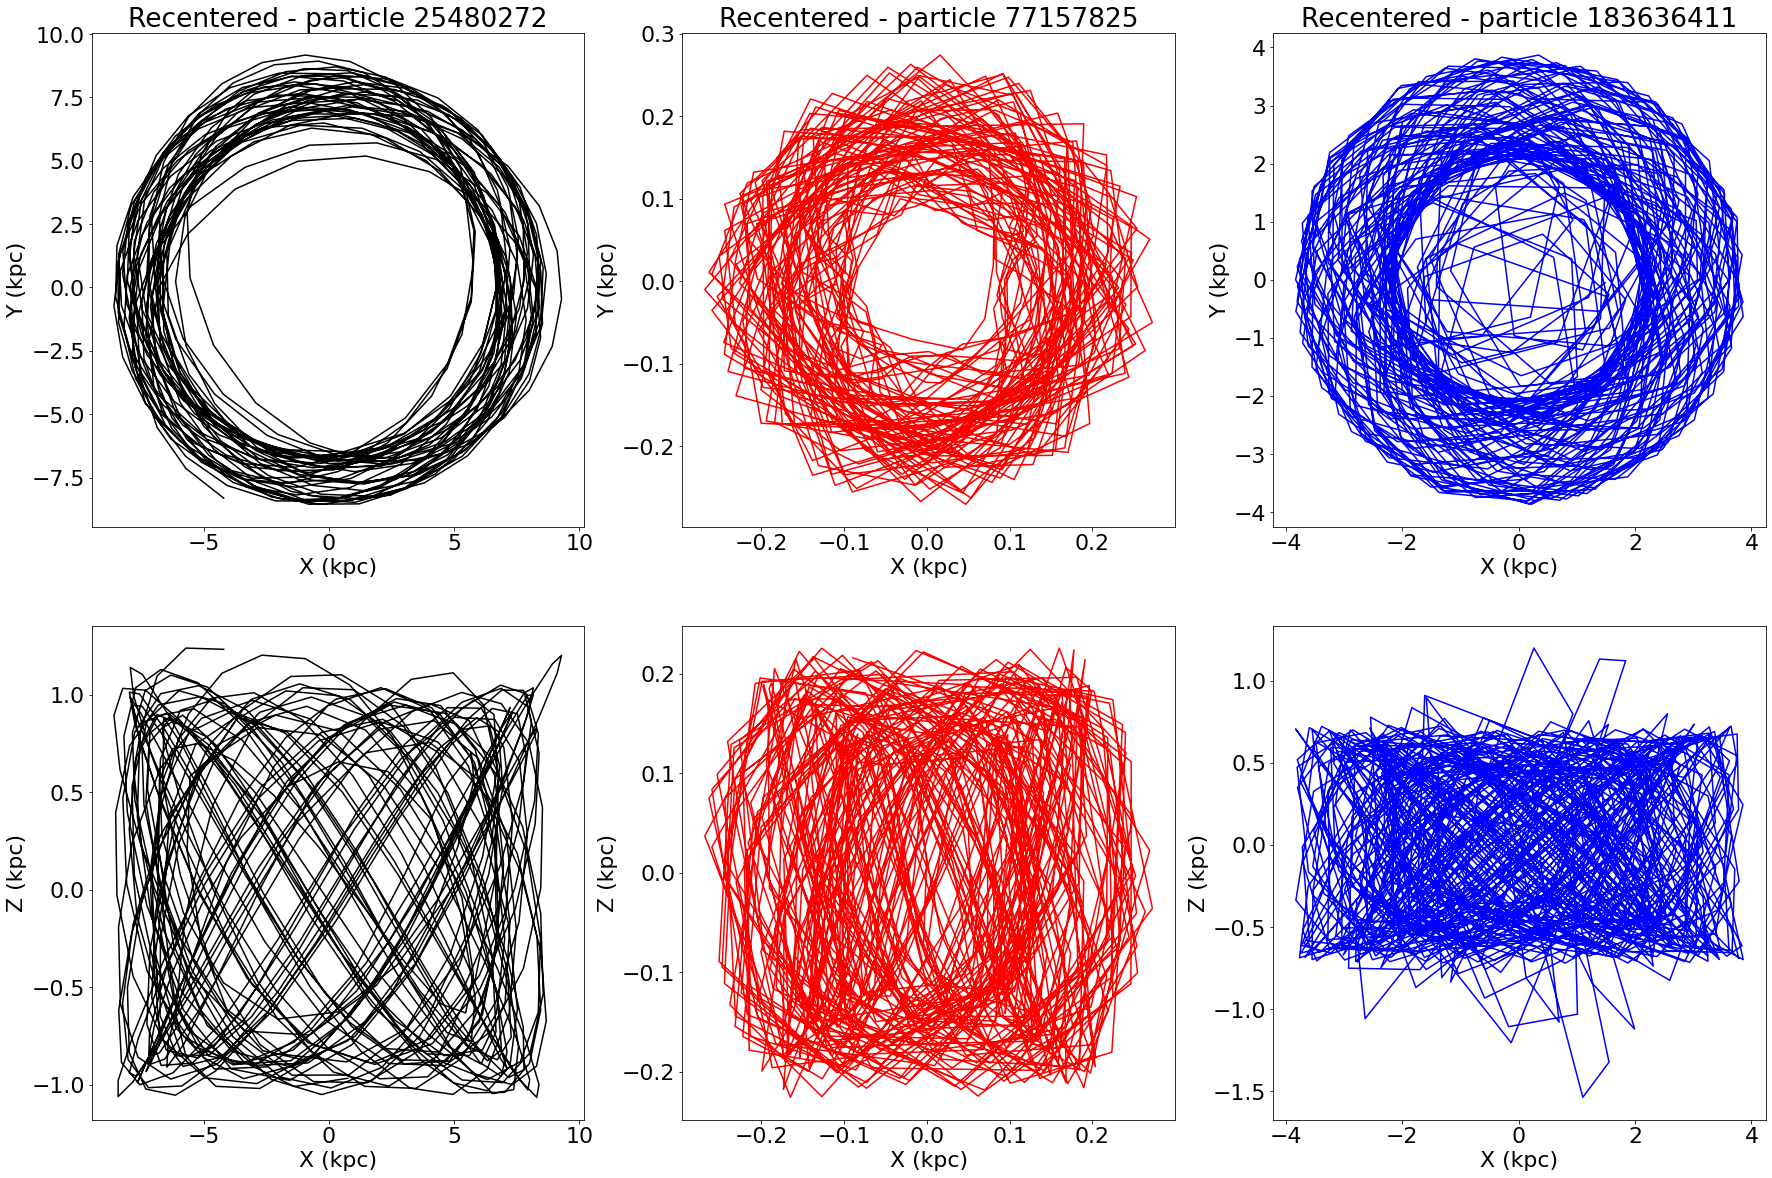

In [21]:
#let's plot the paths now that they're recentered
fig, (ax1, ax2) = plt.subplots(2,3, figsize=(30, 20)) #two rows of three plots, 10x10 each
ax1[0].set_title('Recentered - particle '+ str(recen_path_0['idd'][0])) #title the plot with the particle ID
ax1[0].plot(recen_path_0['x'], recen_path_0['y'], c='k')#a plot of x vs y, shown with a black line
ax1[0].set_xlabel('X (kpc)') #set axis labels
ax1[0].set_ylabel('Y (kpc)')

ax2[0].plot(recen_path_0['x'], recen_path_0['z'], c='k') #a plot of x vs z, shown with a black line
ax2[0].set_xlabel('X (kpc)') #set axis labels
ax2[0].set_ylabel('Z (kpc)')

#next particle path!
ax1[1].set_title('Recentered - particle '+ str(recen_path_1['idd'][0])) 
ax1[1].plot(recen_path_1['x'], recen_path_1['y'], c='r') #a plot of x vs y, shown with a red line
ax1[1].set_xlabel('X (kpc)') #set axis labels
ax1[1].set_ylabel('Y (kpc)')

ax2[1].plot(recen_path_1['x'], recen_path_1['z'], c='r') #a plot of x vs z, shown with a red line
ax2[1].set_xlabel('X (kpc)') 
ax2[1].set_ylabel('Z (kpc)')

#next particle path!
ax1[2].set_title('Recentered - particle '+ str(recen_path_2['idd'][0])) #title the plot with the particle ID
ax1[2].plot(recen_path_2['x'], recen_path_2['y'], c='b') #a plot of x vs y, shown with a blue line
ax1[2].set_xlabel('X (kpc)') #set axis labels
ax1[2].set_ylabel('Y (kpc)')

ax2[2].plot(recen_path_2['x'], recen_path_2['z'], c='b') #a plot of x vs z, shown with a blue line
ax2[2].set_xlabel('X (kpc)') #set axis labels
ax2[2].set_ylabel('Z (kpc)')

# These look much more like normal orbits!